In [2]:
#from qibo.models.variational import VQE
# from boostvqe.ansatze import build_circuit
from qibo import hamiltonians, Circuit,gates
#from pathlib import Path
import numpy as np
#import scipy

In [7]:
t = 0.01
steps = 1
delta=0.5
nqubits=2


In [1]:
def _add_gates(circuit,list_q_i,list_q_ip1,t,delta,steps, coeff=1):
    t = t*coeff
    dt = t/steps
    alpha = -dt
    beta = -dt
    gamma = -delta*dt

    circuit.add(gates.RZ(q_ip1, -np.pi/2) for q_ip1 in list_q_ip1)
    circuit.add(gates.CNOT(q_ip1, q_i) for q_i,q_ip1 in zip(list_q_i,list_q_ip1))
    circuit.add(gates.RZ(q_i, -2*gamma + np.pi/2) for q_i in list_q_i)
    circuit.add(gates.RY(q_ip1, -np.pi/2+2*alpha) for q_ip1 in list_q_ip1)
    circuit.add(gates.CNOT(q_i, q_ip1) for q_i,q_ip1 in zip(list_q_i,list_q_ip1))
    circuit.add(gates.RY(q_ip1, -2*beta + np.pi/2) for q_ip1 in list_q_ip1)
    circuit.add(gates.CNOT(q_ip1, q_i) for q_i,q_ip1 in zip(list_q_i,list_q_ip1))
    circuit.add(gates.RZ(q_i, np.pi/2) for q_i in list_q_i)
    return circuit

In [13]:
circuit = Circuit(2)
c1 = _add_gates(circuit,[0],[1],t,delta,1,1)
print(c1.draw())

q0: ────X─RZ─o────X─RZ─
q1: ─RZ─o─RY─X─RY─o────


In [14]:
circuit = Circuit(2)
c2 = _add_gates(circuit,[0],[1],t,delta,1,1/2)
print(c2.draw())

q0: ────X─RZ─o────X─RZ─
q1: ─RZ─o─RY─X─RY─o────


In [21]:
np.linalg.norm(c1.unitary()-(c2+c2).unitary()*np.exp(+1j*np.pi/4))

8.436257876513695e-16

In [17]:
u = c2.unitary()
v = c1.unitary()
np.linalg.norm(u-v@v)

1.5312044458134593

In [51]:
c=0.5

In [5]:
def nqubit_XXZ_decomposition(nqubits,t,delta,steps,c):
    circuit = Circuit(nqubits = nqubits)

    even_numbers = [num for num in range(nqubits) if num % 2 == 0]
    odd_numbers = [num for num in range(nqubits) if num % 2 == 1]

    if nqubits%2 == 0:
        even_numbers_end_0 = [num for num in range(1,nqubits) if num % 2 == 0]
        even_numbers_end_0.append(0)
        
        circuit = _add_gates(circuit,even_numbers,odd_numbers,t,delta,steps,c)
        circuit = _add_gates(circuit,odd_numbers,even_numbers_end_0,t,delta,steps)
        circuit = _add_gates(circuit,even_numbers,odd_numbers,t,delta,steps,c)

    elif nqubits%2 == 1:
        circuit = _add_gates(circuit,even_numbers[:-1],odd_numbers,t,delta,steps)
        circuit = _add_gates(circuit,odd_numbers,even_numbers[1:],t,delta,steps)
        circuit = _add_gates(circuit,[nqubits-1],[0],t,delta,steps)


    multi_layer = Circuit(nqubits = nqubits)
    for step in range(steps):
        multi_layer += circuit
    return multi_layer


In [8]:
h_xxz = hamiltonians.XXZ(nqubits=nqubits, delta = delta)
u = h_xxz.exp(t)
circ = nqubit_XXZ_decomposition(nqubits=nqubits,t=t,delta=delta,steps=steps,c=1)
v = circ.unitary()
print(np.linalg.norm(u-np.exp(nqubits*steps*1j*np.pi/4)*v))
print(circ.draw())

1.5309425034460595
q0: ────X─RZ─o────X─RZ─RZ─o─RY─X─RY─o───────X─RZ─o────X─RZ─
q1: ─RZ─o─RY─X─RY─o───────X─RZ─o────X─RZ─RZ─o─RY─X─RY─o────


In [56]:
res = []
coeffs = np.linspace(0.1,200.1,300)
for c in coeffs:
    circ = nqubit_XXZ_decomposition(nqubits=nqubits,t=t,delta=delta,steps=steps,c=c)
    v = circ.unitary()
    res.append(np.linalg.norm(u-np.exp(nqubits*steps*1j*np.pi/4)*v))

Text(0, 0.5, '||U-V||')

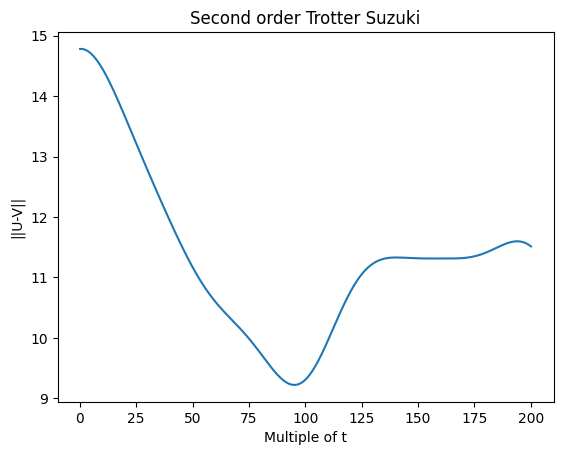

: 

In [59]:
import matplotlib.pyplot as plt
plt.plot(coeffs,res)
plt.title('Second order Trotter Suzuki')
plt.xlabel('Multiple of t')
plt.ylabel('||U-V||')